In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 

try:
    df = pd.read_parquet('../config/no_brick/gz_files/IP_match_trees/hadd.parquet')
except Exception as e:
    print(f"Error: {e}")
    exit()


/home/davidstewart/penv-ML/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/davidstewart/penv-ML/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


0.0
81.17015


/tmp/ipykernel_141179/2357012896.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(categorized)


KEEP: Group in range (1.84e-11, 4.27e-11] has 2648256 events
Group in range (4.27e-11, 9.92e-11] has only 0 events (<100K) -> drop group
KEEP: Group in range (9.92e-11, 2.31e-10] has 2602867 events
Group in range (2.31e-10, 3.05e-10] has only 0 events (<100K) -> drop group
KEEP: Group in range (3.05e-10, 5.36e-10] has 2572780 events
Group in range (5.36e-10, 7.1e-10] has only 0 events (<100K) -> drop group
Group in range (7.1e-10, 9.41e-10] has only 20 events (<100K) -> drop group
Group in range (9.41e-10, 1.25e-09] has only 0 events (<100K) -> drop group
KEEP: Group in range (1.25e-09, 2.19e-09] has 2556134 events
Group in range (2.19e-09, 4.42e-09] has only 0 events (<100K) -> drop group
KEEP: Group in range (4.42e-09, 7.75e-09] has 2551416 events
Group in range (7.75e-09, 1.03e-08] has only 0 events (<100K) -> drop group
KEEP: Group in range (1.03e-08, 2.39e-08] has 2554364 events
Group in range (2.39e-08, 3.64e-08] has only 40 events (<100K) -> drop group
Group in range (3.64e-08, 

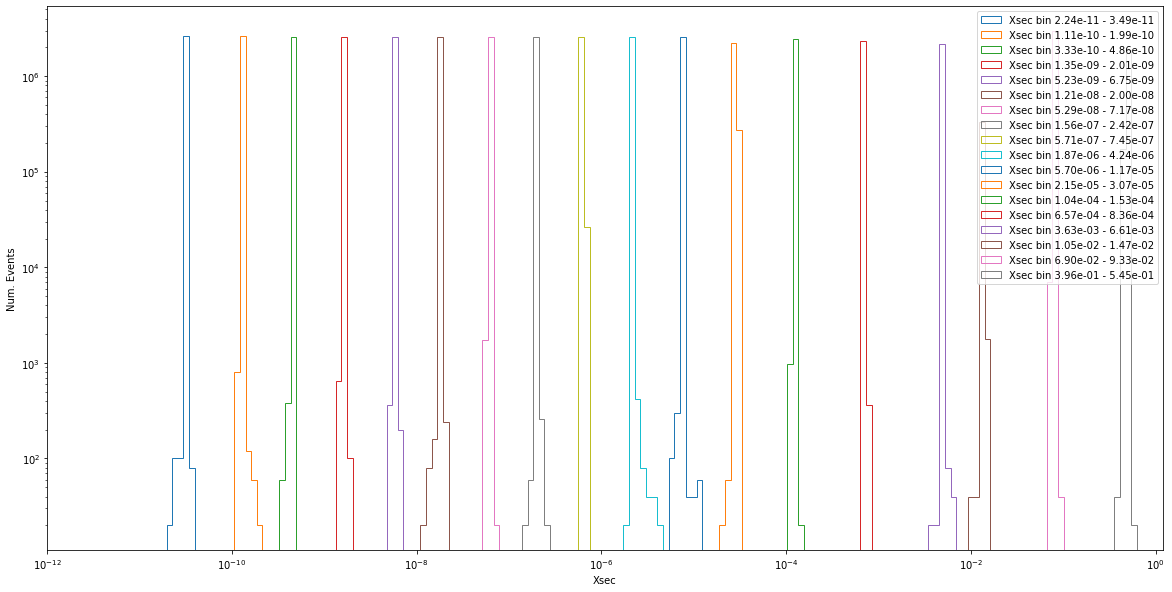

In [2]:
# plot Xsec vs truth_pt and remove outliers
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import os

# df = pd.read_parquet('Xsec_all.parquet')

# cut the Xsec > 1
# df = df[df.Xsec<1.].reset_index(drop=True)

# find the Xsec binning
print(df.truth_pt.min())
print(df.truth_pt.max())
bins = np.logspace(np.log10(df['Xsec'].min()/2.), 1.2, 200)
# bins = np.logspace(1e-12, 10., 200)
# bins = np.linspace(0., 2., 100)
plt.figure(figsize=(20,10))


cnt, edges = np.histogram(df.Xsec, bins=bins)
centers = 0.5*(edges[1:] + edges[:-1])
# calculate the lower boundairekjkks
bincount = [] # enter tuples of count, lower bound, upper bound
is_in = False
up_edge = 0
bin_sum = 0
new_edges = []
for i in range(len(centers)-1, -1, -1):
    if cnt[i] == 0:
        if is_in:
            is_in = False
            bincount.append((bin_sum, centers[i], up_edge))
            if up_edge < 1.:
                new_edges.extend([centers[i], up_edge])
            bin_sum = 0
    else:
        if is_in:
            bin_sum += cnt[i]
        else:
            is_in = True
            up_edge = centers[i+1]
            bin_sum += cnt[i]

# for line in bincount:
    # print(line)

new_edges.sort()
new_edges = list(dict.fromkeys(new_edges))

y_low = [x[1] for x in bincount]
y_up  = [x[2] for x in bincount]
y_cnt = [x[0] for x in bincount]
ye5 = [1e0 for x in bincount]
ye6 = [1.3e0 for x in bincount]
ye7 = [1.5e0 for x in new_edges]

categorized = pd.cut(df.Xsec, bins=new_edges);
grouped = df.groupby(categorized)

arr_cnt = 0
arr_df = {}

if not os.path.isdir('Xsec_groups'):
    os.mkdir('Xsec_groups')

for name, group in grouped:
    if (group.shape[0] < 100000):
        print(f'Group in range {name} has only {group.shape[0]} events (<100K) -> drop group')
    else:
        print(f'KEEP: Group in range {name} has {group.shape[0]} events')
        arr_df[name] = group
        group.to_parquet(f'Xsec_groups/df_Xsec_{arr_cnt}.parquet')
        arr_cnt += 1

        



# plt.scatter(centers, cnt)
# plt.scatter(y_low, ye5, color='r', label="low-bin edge")
# plt.scatter(y_up, ye6, color='g', label='up-bin edge')
# plt.scatter(new_edges, ye7, color='b', label='up-bin edge')
# plt.hist(df.Xsec, bins=bins, histtype='step', color='r', label='histogram of events')
# plt.hist(group_filtered.Xsec, bins=bins, histtype='step', color='g', label='histogram of events')


for df in arr_df.values():
    plt.hist(df.Xsec, bins=bins, histtype='step', label=f'Xsec bin {df.Xsec.min():.2e} - {df.Xsec.max():.2e}')

plt.xlim(1e-12, 1.2)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Num. Events')
plt.xlabel('Xsec')
plt.legend()

nbelow = df[df.Xsec<1.].shape[0]
nabove = df[df.Xsec>1.].shape[0]
print(nbelow/(nbelow+nabove))

print(df[df.Xsec<1.].shape[0])
print(df[df.Xsec>1.].shape[0])

# df = df[df.Xsec<1.].reset_index(drop=True)

In [3]:
import numpy as np
import pandas as pd


def cut_right_outliers(df, val_truth, val_reco, bin_edges):
    ''' 
        take the pd.DataFrame pd and array and boundaries
        find the location of the of the first zero bin after the maximum
    '''
    i_max_truth = np.argmax(val_truth)
    cut_right_truth = bin_edges[-1]
    for index in range(i_max_truth, len(val_truth)):
        if val_truth[index] == 0:
            cut_right_truth = bin_edges[index]+1
            break
    
    i_max_reco = np.argmax(val_reco)
    cut_right_reco = bin_edges[-1]
    for index in range(i_max_reco, len(val_reco)):
        if val_reco[index] == 0:
            cut_right_reco = bin_edges[index]+1
            break

    df = df[(df.truth_pt < cut_right_truth) & (df.reco_pt < cut_right_reco)]
    return df


Xsec_groups/df_Xsec_4.parquet
{'mean_Xsec': 5.647100120853565e-09, 'scale_factor': 2.213320023411927e-15, 'arr_eff_IPtoT': 0.9999780514036127, 'arr_eff_TtoR': 0.9991486893264768, 'arr_eff_eta': 0.8946703813135791, 'arr_total': 2551416.0, 'total_Xsec': 0.586668327618283}
Xsec_groups/df_Xsec_9.parquet
{'mean_Xsec': 2.155283937099739e-06, 'scale_factor': 8.408613097526824e-13, 'arr_eff_IPtoT': 0.9998728145362842, 'arr_eff_TtoR': 0.994892034680006, 'arr_eff_eta': 0.7392693220444676, 'arr_total': 2563186.0, 'total_Xsec': 0.586668327618283}
Xsec_groups/df_Xsec_8.parquet
{'mean_Xsec': 6.424787670766818e-07, 'scale_factor': 2.5010959135868376e-13, 'arr_eff_IPtoT': 0.9998874956253706, 'arr_eff_TtoR': 0.9967432353513724, 'arr_eff_eta': 0.768327060877649, 'arr_total': 2568789.0, 'total_Xsec': 0.586668327618283}
Xsec_groups/df_Xsec_10.parquet
{'mean_Xsec': 7.577318683615886e-06, 'scale_factor': 2.971263317525123e-12, 'arr_eff_IPtoT': 0.9998506000115285, 'arr_eff_TtoR': 0.9913593900745935, 'arr_eff

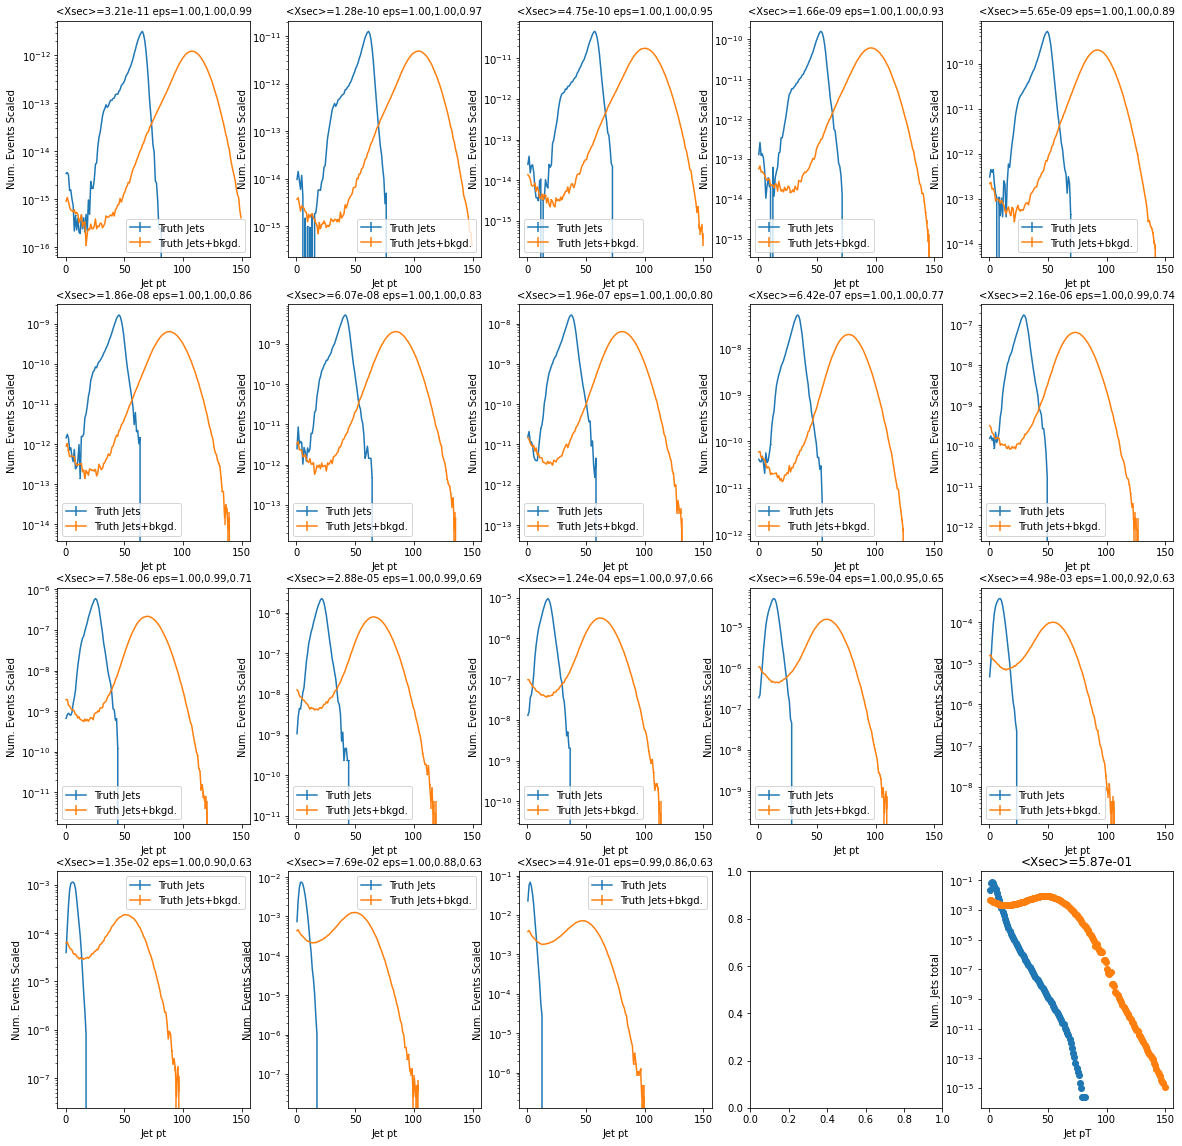

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import json
import os

# make the response matrix for the Xsec (note that it will need corrections, too...)

fig, axs = plt.subplots(4,5, figsize=(20,20))

bins=np.linspace(0., 150., 151)

sum_truth = np.zeros(150)
sum_reco = np.zeros(150)

# get the total normalizing cross section
sum_Xmean = 0
for file in glob.glob('Xsec_groups/df_Xsec_*.parquet'):
    sum_Xmean += pd.read_parquet(file).Xsec.mean()

for file in glob.glob('Xsec_groups/df_Xsec_*.parquet'):
    print(file)
    i = int(file.split('_')[-1].split('.')[0])
    df = pd.read_parquet(file)
    total = df.shape[0]
    n_IPtoT = df[df.matched_IPtoT].shape[0]
    n_TtoR = df[df.matched_TtoR & df.matched_IPtoT].shape[0]
    n_eta = df[df.matched_TtoR & df.matched_IPtoT & (np.abs(df.truth_eta) < 0.6)].shape[0]

    arr_eff_IPtoT = n_IPtoT/total
    arr_eff_TtoR = n_TtoR/n_IPtoT
    arr_eff_eta = n_eta/n_TtoR
    arr_total = total

    df = df[df.matched_TtoR & df.matched_IPtoT & (np.abs(df.truth_eta) < 0.6)].reset_index(drop=True)
    scale_factor = df.Xsec.mean() / total


    # Write scale factor and arr_eff values to a .json file
    data = {
        'mean_Xsec' : float(df.Xsec.mean()),
        'scale_factor': float(scale_factor),
        'arr_eff_IPtoT': float(arr_eff_IPtoT),
        'arr_eff_TtoR': float(arr_eff_TtoR),
        'arr_eff_eta': float(arr_eff_eta),
        'arr_total': float(arr_total),
        'total_Xsec': float(sum_Xmean)
    }

    fout = f'Xsec_groups/scale_data_{i}.json'
    if os.path.isfile(fout):
        os.remove(fout)

    with open(f'Xsec_groups/scale_data_{i}.json', 'w') as f:
        print(data)
        json.dump(data, f)

    bins = np.linspace(0., 150., 151)
    truth, bins = np.histogram(df['truth_pt'], bins=bins)
    reco, _ = np.histogram(df['reco_pt'], bins=bins)

    df = cut_right_outliers(df, truth, reco, bins)

    truth, bins = np.histogram(df['truth_pt'], bins=bins)
    reco, _ = np.histogram(df['reco_pt'], bins=bins)

    truth_err = np.array([np.sqrt(x)/x if x != 0 else 0 for x in truth])
    reco_err = np.array([np.sqrt(x)/x if x != 0 else 0 for x in reco])

    truth = truth * scale_factor
    truth_err = truth_err * scale_factor

    reco = reco * scale_factor
    reco_err = reco_err * scale_factor

    centers = 0.5*(bins[1:] + bins[:-1])

    ax = axs[i//5, i%5]
    ax.errorbar(centers, truth, yerr=truth_err, label='Truth Jets')
    ax.errorbar(centers, reco, yerr=reco_err, label='Truth Jets+bkgd.')
    # ax.hist(df['truth_pt'], bins=bins, histtype='step', label='Truth Jets')
    # ax.hist(df['reco_pt'], bins=bins, histtype='step', label='Truth Jets+bkgd.')
    ax.set_yscale('log')
    ax.set_ylabel('Num. Events Scaled')
    ax.set_xlabel('Jet pt')
    ax.set_title(f'<Xsec>={df.Xsec.mean():.2e} eps={n_IPtoT/total:.2f},{n_TtoR/n_IPtoT:.2f},{n_eta/n_TtoR:.2f}',fontsize=10)
    ax.legend()

    sum_truth += truth
    sum_reco += reco

ax = axs[19//5, 19%5]
ax.scatter(centers, sum_truth, label='Truth Jets')
ax.scatter(centers, sum_reco, label='Truth Jets+bkgd.')
ax.set_yscale('log')
ax.set_ylabel('Num. Jets total')
ax.set_xlabel('Jet pT')
ax.set_title(f'<Xsec>={sum_Xmean:.2e}')
plt.savefig('Xsec_overall.pdf')
# plt.hist(df['truth_pt'], bins=100, histtype='step')
# plt.hist(df['reco_pt'], bins=100, histtype='step')
# plt.yscale('log')
# plt.ylabel('Num. Events')
# plt.xlabel('Jet pt')
# plt.title(r'Jet pt distribution $\langle X_\mathrm{sec}\rangle ='+ f'{df.Xsec.mean():.2e}$')